In [602]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.ndimage.interpolation import shift

In [603]:
def create_dataset(dataset,look_back=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back),:])
        dataY.append(dataset[(i+look_back),:])
    return np.array(dataX), np.array(dataY)

In [604]:
np.random.seed(7)

In [605]:
data = pd.read_csv('test.csv' , header=None, usecols=[19])
dataset = data.values
dataset = dataset[len(dataset)-500:]
print(len(dataset))
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset)*0.7)
test_size = (len(dataset)) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

500


In [606]:
look_back = 100
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

In [607]:
model = Sequential()
model.add(LSTM(4, input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(trainX,trainY,epochs=100,batch_size=1,verbose=2)

Epoch 1/100
 - 0s - loss: 0.0362
Epoch 2/100
 - 0s - loss: 0.0122
Epoch 3/100
 - 0s - loss: 0.0098
Epoch 4/100
 - 0s - loss: 0.0083
Epoch 5/100
 - 0s - loss: 0.0079
Epoch 6/100
 - 0s - loss: 0.0063
Epoch 7/100
 - 0s - loss: 0.0064
Epoch 8/100
 - 0s - loss: 0.0058
Epoch 9/100
 - 0s - loss: 0.0053
Epoch 10/100
 - 0s - loss: 0.0049
Epoch 11/100
 - 0s - loss: 0.0046
Epoch 12/100
 - 0s - loss: 0.0046
Epoch 13/100
 - 0s - loss: 0.0045
Epoch 14/100
 - 0s - loss: 0.0041
Epoch 15/100
 - 0s - loss: 0.0040
Epoch 16/100
 - 0s - loss: 0.0038
Epoch 17/100
 - 0s - loss: 0.0039
Epoch 18/100
 - 0s - loss: 0.0039
Epoch 19/100
 - 0s - loss: 0.0038
Epoch 20/100
 - 0s - loss: 0.0036
Epoch 21/100
 - 0s - loss: 0.0034
Epoch 22/100
 - 0s - loss: 0.0039
Epoch 23/100
 - 0s - loss: 0.0034
Epoch 24/100
 - 0s - loss: 0.0032
Epoch 25/100
 - 0s - loss: 0.0033
Epoch 26/100
 - 0s - loss: 0.0035
Epoch 27/100
 - 0s - loss: 0.0033
Epoch 28/100
 - 0s - loss: 0.0033
Epoch 29/100
 - 0s - loss: 0.0033
Epoch 30/100
 - 0s - lo

In [608]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [609]:
future_dataset = []
futurePredict = []
future_dataset.append(dataset[-look_back:,:])
future_dataset = np.array(future_dataset)
future_dataset = np.reshape(future_dataset,(future_dataset.shape[0],1,future_dataset.shape[1]))
for i in range(100):
    p = model.predict(future_dataset)
    future_dataset[0,0] = shift(future_dataset[0,0],-1,cval=p[0,0])
    futurePredict.append(p[0,0])
futurePredict = scaler.inverse_transform([futurePredict])

In [610]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [611]:
trainScore = math.sqrt(mean_squared_error(trainY[:,0],trainPredict[:,0]))
print("Train score: %.2f RMSE" % trainScore)
testScore = math.sqrt(mean_squared_error(testY[:,0],testPredict[:,0]))
print("Test score: %.2f RMSE" % testScore)

Train score: 1.55 RMSE
Test score: 4.49 RMSE


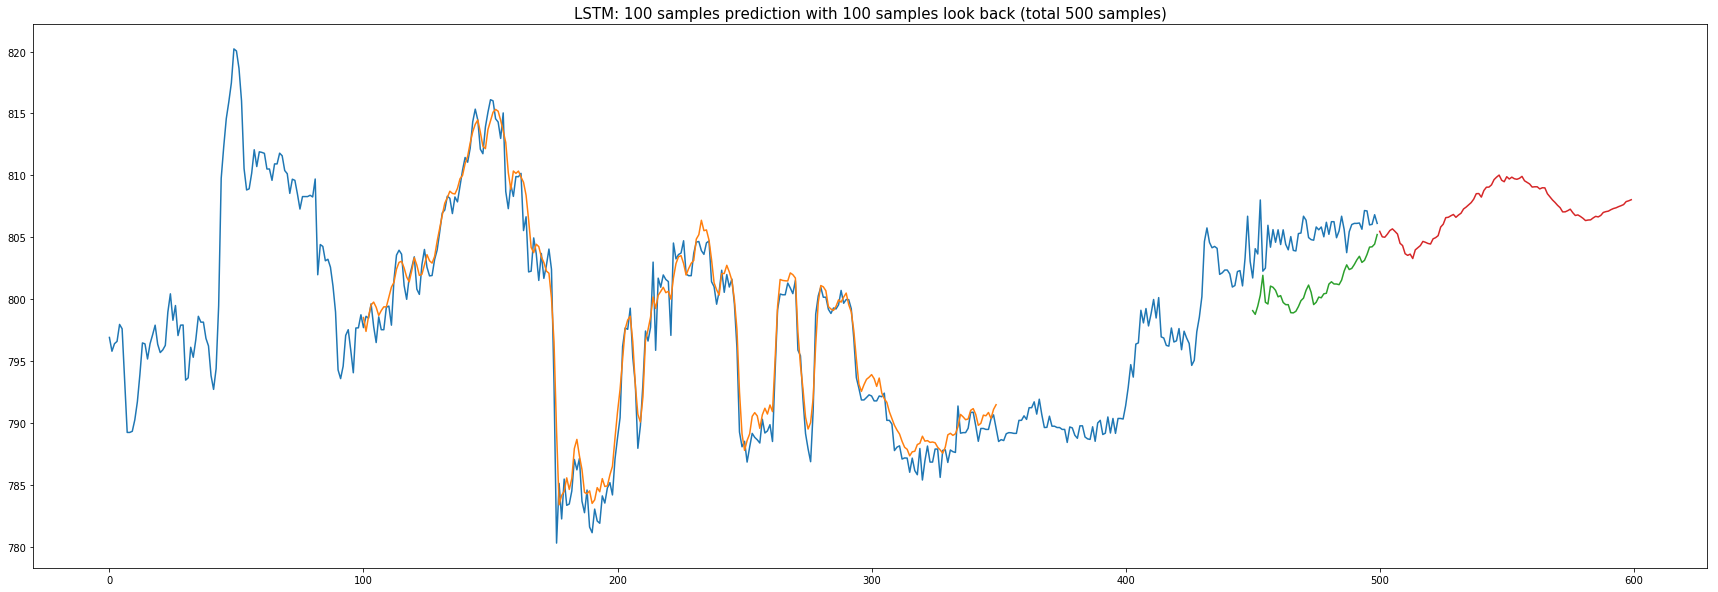

In [612]:
trainPredictPlot = np.zeros(shape=(len(dataset)+len(future_predict),1))
#trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back,:] = trainPredict

testPredictPlot = np.zeros(shape=(len(dataset)+len(future_predict),1))
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset),:] = testPredict

futurePredictPlot = np.zeros(shape=(len(dataset)+len(future_predict),1))
futurePredictPlot[:,:] = np.nan
futurePredictPlot[len(dataset):,:] = np.transpose(futurePredict)

plt.figure(figsize=(30,10))
plt.title('LSTM: %d samples prediction with %d samples look back (total %d samples)' % (len(future_predict),look_back,len(dataset)),fontsize=15)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.plot(futurePredictPlot)
plt.savefig('LSTM_prediction.png')
plt.show()